<a href="https://colab.research.google.com/github/iIsunnyIi/Funnel-Transformer/blob/main/Funnel_IntentRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-transformers
!pip install transformers

     |████████████████████████████████| 184kB 16.6MB/s 
     |████████████████████████████████| 1.1MB 33.7MB/s 
     |████████████████████████████████| 133kB 50.4MB/s 
     |████████████████████████████████| 890kB 45.5MB/s 
     |████████████████████████████████| 7.1MB 51.4MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=df9a3557cfd4a0ce3fd8b07f7586464883c63d5b38edaf8caf7c5432cc1f9506
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.38 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.4MB 16.5MB/s 
     |████████████████████████████████| 2.9MB 51.1MB/s 


In [2]:
!nvidia-smi

Thu Dec 17 06:27:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
torch.cuda.is_available()

True

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import class_weight

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import class_weight

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
>>> from transformers import FunnelTokenizer, FunnelForSequenceClassification
>>> import torch

In [9]:
## Check if Cuda is Available
print(torch.cuda.is_available())

True


In [ ]:
## Importing Datasets

In [11]:
train = pd.read_csv("/content/drive/MyDrive/Funnel Data/train.csv", header = None, names = ["utterance", "slots", "label"])
test = pd.read_csv("/content/drive/MyDrive/Funnel Data/test.csv", header = None, names = ["utterance", "slots", "label"])
validation = pd.read_csv("/content/drive/MyDrive/Funnel Data/dev.csv", header = None, names = ["utterance", "slots", "label"])
 
#collating the data 
dataset1 = train.append(validation).reset_index(drop=True)
dataset = dataset1.append(test).reset_index(drop=True)
dataset = dataset[["utterance", "label"]]
dataset.head()

,utterance,label
0,BOS Sir I created a new env with python 3.7 bu...,need_help
1,BOS above problem how will it solve ?? EOS,need_help
2,BOS Hello sir is there anyone EOS,Greetings
3,BOS i think canvas login problem was due to br...,great
4,BOS Please provide me with the link to python ...,community_class_link


In [12]:
#Removing BOS
corpus =[]
 
for i in range(len(dataset["utterance"])):
  val = dataset["utterance"][i]
  match =re.sub("[^a-zA-Z]", " ", val)
  #print(match)
  match = re.sub("BOS ", "", match)
  #print(match)
  match = re.sub(" EOS", "", match)
  #print(match)
  match = "".join(match)
  
  corpus.append(match)
 
dataset["utterance"] = pd.DataFrame(corpus)
dataset

,utterance,label
0,Sir I created a new env with python but th...,need_help
1,above problem how will it solve,need_help
2,Hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,Please provide me with the link to python class,community_class_link
...,...,...
4334,x tf Variable xinit tf global variables init...,need_help
4335,partlist type started alt OId ad d a ...,O
4336,Thanks you sir,Thank_you
4337,URIObject uri https api asm skype com v ob...,O


##ERROR 1: "There are intents which are least populated (ie. just 1 utterance per intent is there), for stratification minimum number of groups for any class cannot be less than 2 ---> UNABLE TO DO STRATIFICATION."

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


##Error 2: I tried removing the least populated classes by running the following code, and even reset the index, but still KeyError occured while splitting test and train dataset.

dataset = dataset[~dataset["label"].isin(["chatbot_telegram_connection_issue", "select_course_id", "Exception_builtin_errors", "str_method_output", "large_data_handle_prod_query", "file_not_found", "doubt_session_link", "rasa_installation", "github_how_to_use", "aws_lex_account_query", "CNN_code_error","aws_lex_smtp_error", "refer_class_lecture", "then_reply", "conda_environment", "aws_deployment_error", "azure_luis_understanding_issue", "anaconda_navigator_open", "assignment_by_github","azure_luis_deployment","pycharm_path_set","books_availablity_dashboard", "word_file_input_query", "large_data_handle_query","assignment_matplotlib", "dialog_flow_email_issue", "usecase_document_contains_letter", "pycharm_error", "enter_query_indetails", "logistic_regression", "python_abstract", "assingment_uploading_error", "chatbot_issue", "course_registration", "selennium_installation", "visualization_powerbi_query","bot_reply", "zoom_screen_share", "python_oops", "choosing_no_of_epochs", "PlotlyRequestError","heroku_installation", "list_comprehensions","pandas_general_query","canvas_details_edit", "assignment_exception_handling", "rasa_nlu_details", "mysql", "anconda_installation", "data_science_architecture_class", "decision_tree_ML", "python_super_class", "system_issue", "numpy_error", "ineuron_challenge_details", "assignment_list_comprehension", "refer_syllabus"])]


###dataset.reset_index(drop=True)



Query : How to use class-weights with BERT/RoBERTa

"""class_weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, 1)), np.argmax(y_train, 1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks = [es])"""

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 14400x14400 with 0 Axes>

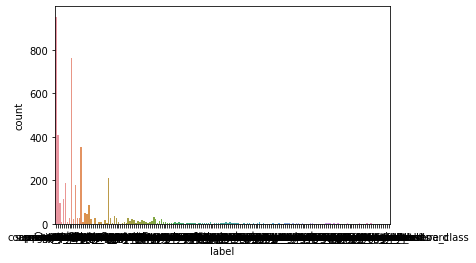

<Figure size 14400x14400 with 0 Axes>

In [13]:
chart = sns.countplot(dataset["label"])
plt.figure(figsize=(200,200))
#plt.title("No. of utterances per intent")

Clearly, an imbalanced data

In [15]:
"""from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight("balanced", np.unique(dataset["label"]), dataset["label"]))
dataset["label"].value_counts()


class_weights.sort()

class_weights"""

'from sklearn.utils import class_weight\nclass_weights = list(class_weight.compute_class_weight("balanced", np.unique(dataset["label"]), dataset["label"]))\ndataset["label"].value_counts()\n\n\nclass_weights.sort()\n\nclass_weights'

In [16]:
dataset["label"].value_counts()

need_help                        952
O                                763
Greetings                        408
Thank_you                        353
good_bye                         213
                                ... 
assignment_list_comprehension      1
file_not_found                     1
assingment_uploading_error         1
Exception_builtin_errors           1
aws_lex_smtp_error                 1
Name: label, Length: 171, dtype: int64

In [17]:
label_to_ix = {}
for label in dataset.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
label_to_ix

{'CNN_code_error': 127,
 'Dashboard_access': 39,
 'Dashboard_details': 83,
 'EDA_code': 111,
 'Exception_builtin_errors': 97,
 'GCP_chatbot': 78,
 'Greetings': 1,
 'NewBatch_details': 54,
 'O': 8,
 'PlotlyRequestError': 33,
 'Plotly_installation': 60,
 'Thank_you': 13,
 'anaconda_jnotebook_run': 89,
 'anaconda_macos': 117,
 'anaconda_navigator_open': 21,
 'anaconda_prompt': 126,
 'anconda_installation': 151,
 'assignment_by_github': 150,
 'assignment_data_visulization': 57,
 'assignment_doubt': 7,
 'assignment_evaluation': 96,
 'assignment_exception_handling': 128,
 'assignment_issue': 131,
 'assignment_link': 86,
 'assignment_list_comprehension': 134,
 'assignment_matplotlib': 113,
 'assignment_numpy': 88,
 'assignment_pandas': 6,
 'assignment_pandas_link': 77,
 'assignment_powerbi': 123,
 'assignment_python': 43,
 'assignment_stats': 53,
 'assignment_submittion': 50,
 'assingment_uploading_error': 109,
 'aws_deployment_error': 112,
 'aws_lex_account_query': 147,
 'aws_lex_smtp_error'

In [ ]:
## Loading RoBERTa classes

In [21]:
from transformers import FunnelModel, RobertaTokenizer
from transformers import FunnelForSequenceClassification, FunnelConfig

In [22]:
config = FunnelConfig.from_pretrained('funnel-transformer/small-base')
config.num_labels = len(list(label_to_ix.values()))
config

FunnelConfig {
  "activation_dropout": 0.0,
  "architectures": [
    "FunnelBaseModel"
  ],
  "attention_dropout": 0.1,
  "attention_type": "relative_shift",
  "block_repeats": [
    1,
    1,
    1
  ],
  "block_sizes": [
    4,
    4,
    4
  ],
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "hidden_act": "gelu_new",
  "hidden_dropout": 0.1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "L

In [23]:
tokenizer = FunnelTokenizer.from_pretrained('funnel-transformer/small-base')
model = FunnelForSequenceClassification(config)

In [ ]:
## Feature Preparation

In [24]:
def prepare_features(seq_1, max_seq_length = 300, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence length
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
    return torch.tensor(input_ids).unsqueeze(0), input_mask

In [25]:
msg = "My dog is cute!"
prepare_features(msg)

(tensor([[  101,  2026,  3899,  2003, 10140,   999,   102]]),
 [1, 1, 1, 1, 1, 1, 1])

In [ ]:
## Dataset Loader Classes

In [26]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        utterance = self.data.utterance[index]
        label = self.data.label[index]
        X, _  = prepare_features(utterance)
        y = label_to_ix[self.data.label[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [27]:
train_size = 0.8
train_dataset=dataset.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=dataset.drop(train_dataset.index).reset_index(drop=True)

In [28]:
k = set(train_dataset["label"])
print(len(k))
l = set(test_dataset["label"])
print(len(l))
z = k.intersection(l)
len(z)

158
98


93

In [29]:
print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (4339, 2)
TRAIN Dataset: (3471, 2)
TEST Dataset: (868, 2)


In [30]:
training_set = Intents(train_dataset)
testing_set = Intents(test_dataset)

In [31]:
training_set.__getitem__(0)[0].shape

torch.Size([1, 19])

In [32]:
model(training_set.__getitem__(0)[0])

SequenceClassifierOutput([('logits',
                           tensor([[-2.9197e-01, -5.4363e-02, -2.2016e-01,  6.1515e-01, -9.4346e-01,
                                    -1.8148e-01, -1.1631e-01, -2.6675e-01, -1.1772e-01, -3.2766e-01,
                                     8.4443e-01, -1.7271e-01,  1.1671e-01, -8.0518e-01,  2.9234e-01,
                                     6.8919e-01, -9.3210e-01,  1.2069e+00, -9.1735e-02, -5.0392e-01,
                                     3.4391e-02, -5.2317e-01,  1.2905e-01, -5.9976e-01,  4.1854e-02,
                                     5.6398e-01,  2.4935e-01,  2.4610e-01, -1.7652e-02, -1.6103e-02,
                                     6.7283e-01, -1.0901e-01,  4.9346e-01,  8.2444e-01,  1.2214e-01,
                                    -4.6423e-01, -3.3042e-01, -6.8538e-01, -1.1763e-01, -8.6364e-01,
                                     4.1593e-01,  5.8655e-02, -2.4901e-01,  3.5780e-01, -1.9711e-01,
                                     1.8670e-04, -6.60

In [ ]:
## Training Params

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [34]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'drop_last': False,
          'num_workers': 1}

In [35]:
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)

In [36]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-05
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [37]:
## Test Forward Pass
inp = training_set.__getitem__(0)[0].cuda()
output = model(inp)[0]
print(output.shape)

torch.Size([1, 171])


In [38]:
torch.__version__

'1.7.0+cu101'

In [50]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30522, 768)

In [51]:
max_epochs = 3
model = model.train()
for epoch in tqdm_notebook(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(training_loader):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


EPOCH -- 0



RuntimeError: ignored

In [ ]:
# torch.save(model.state_dict(), 'drive/My Drive/Datasets/roberta_state_dict_'+ str(uuid4())+'.pkl')

In [ ]:
## Load model

In [ ]:
#model_path = '/content/drive/MyDrive/Datasets/roberta_state_dict_11c6ad45-5a57-4a99-b815-bcecabede399.pth'

In [ ]:
#model.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
def get_reply(msg):
  model.eval()
  input_msg, _ = prepare_features(msg)
  if torch.cuda.is_available():
    input_msg = input_msg.cuda()
  output = model(input_msg)[0]
  _, pred_label = torch.max(output.data, 1)
  prediction=list(label_to_ix.keys())[pred_label]
  return prediction

In [ ]:
#label_to_ix.keys()